[*********************100%***********************]  1 of 1 completed


AAPL (3743, 6)


[*********************100%***********************]  1 of 1 completed


MSFT (3743, 6)


[*********************100%***********************]  1 of 1 completed


GOOG (3743, 6)


[*********************100%***********************]  1 of 1 completed


AMZN (3743, 6)


[*********************100%***********************]  1 of 1 completed


TSLA (3621, 6)


[*********************100%***********************]  1 of 1 completed


NFLX (3743, 6)


[*********************100%***********************]  1 of 1 completed


NVDA (3743, 6)


[*********************100%***********************]  1 of 1 completed


INTC (3743, 6)


[*********************100%***********************]  1 of 1 completed


AMD (3743, 6)


[*********************100%***********************]  1 of 1 completed


PYPL (2359, 6)


[*********************100%***********************]  1 of 1 completed


SQ (2262, 6)


[*********************100%***********************]  1 of 1 completed


CRM (3743, 6)


[*********************100%***********************]  1 of 1 completed


ORCL (3743, 6)


[*********************100%***********************]  1 of 1 completed


ADBE (3743, 6)


[*********************100%***********************]  1 of 1 completed


IBM (3743, 6)


[*********************100%***********************]  1 of 1 completed


CSCO (3743, 6)


[*********************100%***********************]  1 of 1 completed


SHOP (2390, 6)


[*********************100%***********************]  1 of 1 completed


UBER (1390, 6)


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Optimal alpha: 0.16234036026068277
Covariance matrix:
 [[1.         0.57979744 0.48459167 0.43057355 0.31742169 0.29257537
  0.45119862 0.34075539 0.39579345 0.38044411 0.35421499 0.36818449
  0.32019893 0.46189935 0.24599334 0.37790317 0.32559347 0.2282739 ]
 [0.57979744 1.         0.58196563 0.51842062 0.28398385 0.32316944
  0.52164272 0.38237265 0.44028169 0.39826249 0.38509025 0.47113341
  0.40457467 0.57581183 0.26132076 0.39555801 0.36691317 0.25659047]
 [0.48459167 0.58196563 1.         0.48381378 0.24646965 0.28938199
  0.42885776 0.30527288 0.37284519 0.35689815 0.36116856 0.38574948
  0.28910278 0.4692778  0.20582274 0.32500736 0.32668847 0.24081607]
 [0.43057355 0.51842062 0.48381378 1.         0.26558276 0.37372425
  0.4211755  0.28080491 0.38506868 0.36861551 0.36900886 0.39386603
  0.2561007  0.4505146  0.17543874 0.26738284 0.39232464 0.24535199]
 [0.31742169 0.28398385 0.24646965 0.26558276 1.         0.19081878
  0.30698557 0.18135327 0.27078382 0.26364314 0.31064164 

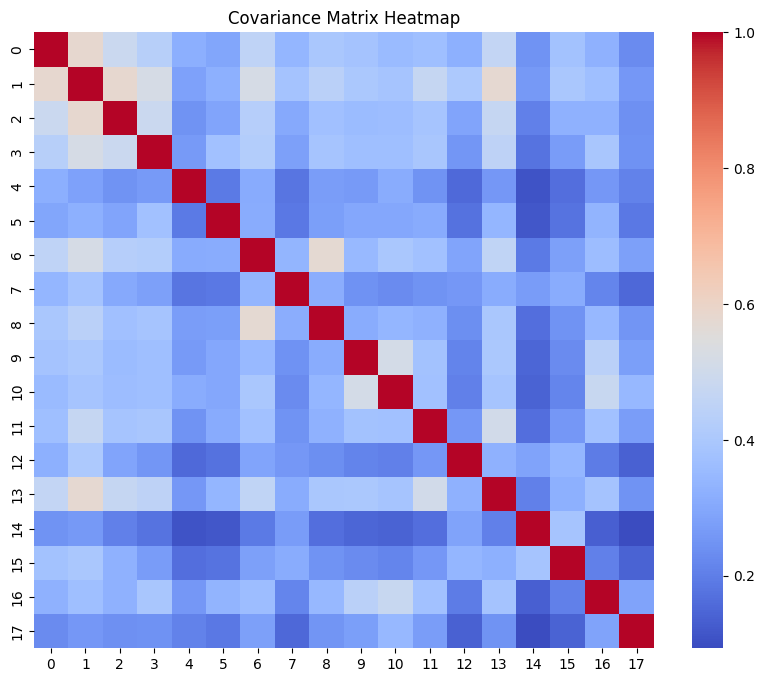

Plotting precision matrix...


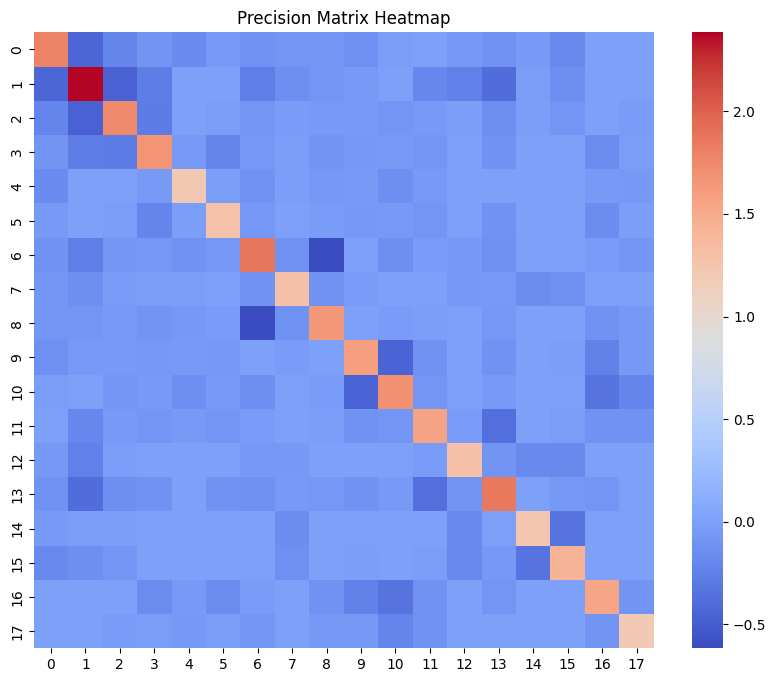

Running Louvain community detection...
Plotting community detection graph...


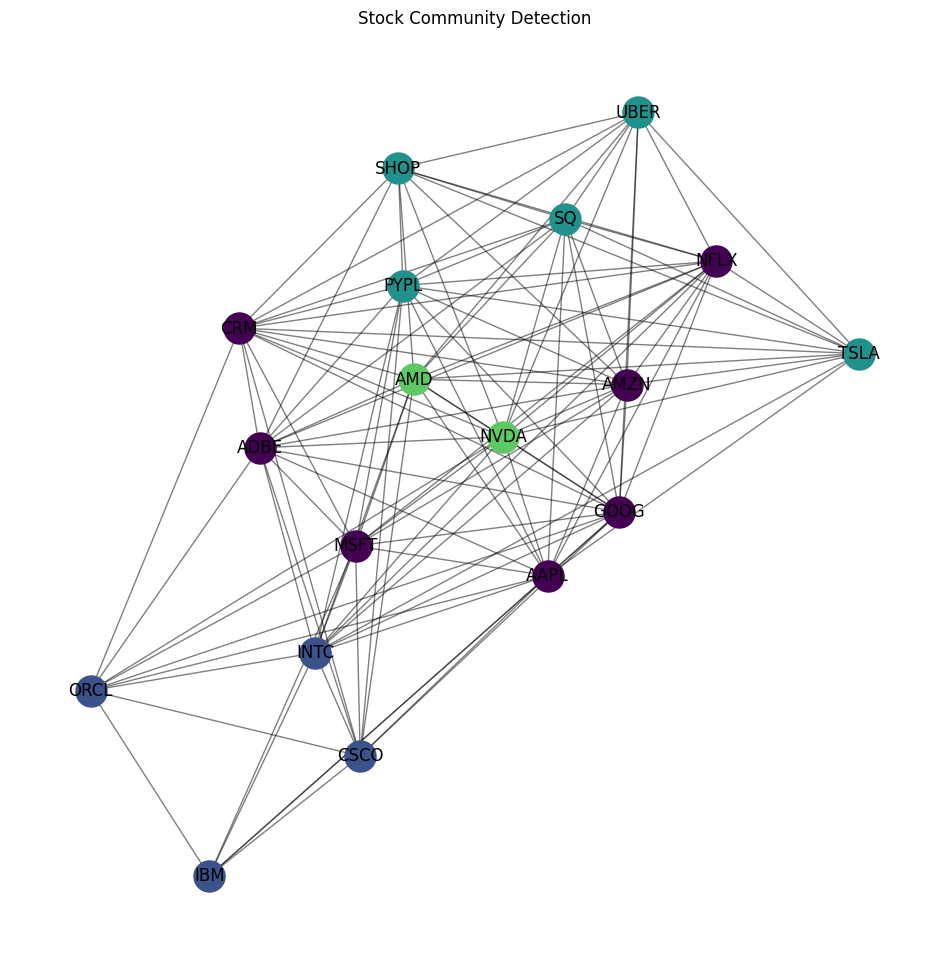

Plotting Gaussian Graphical Model...


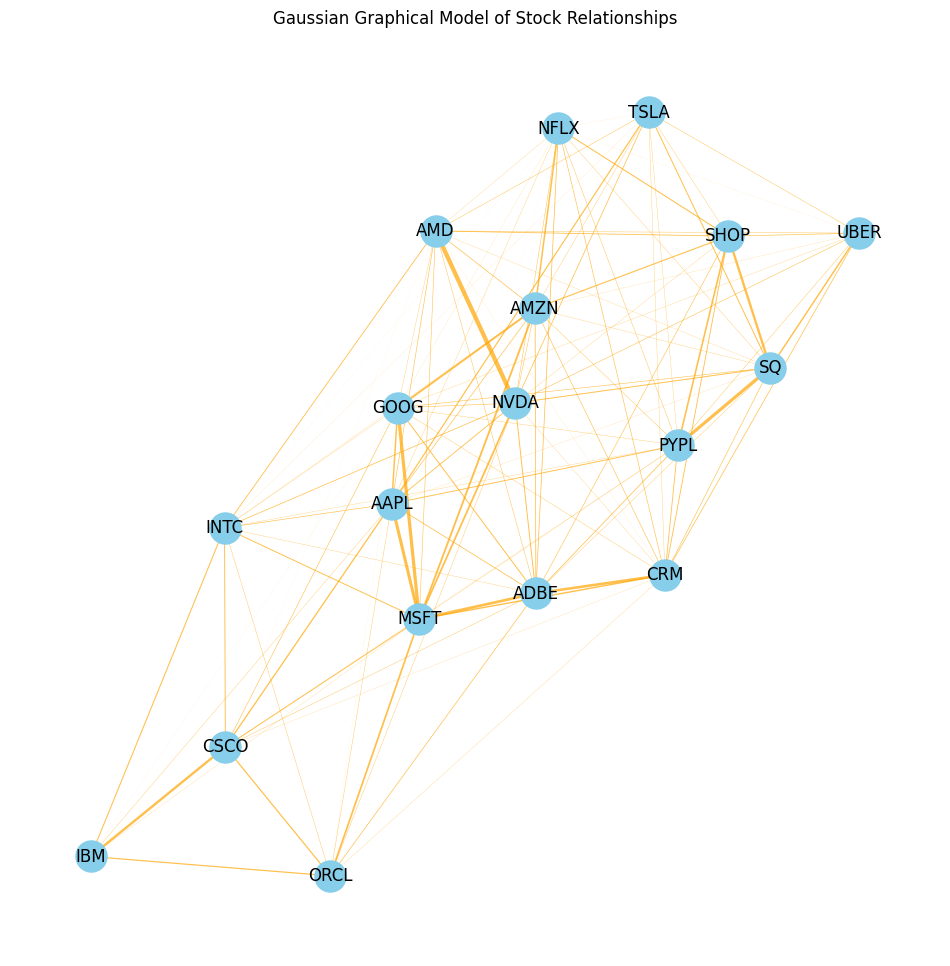

In [ ]:
import datetime
import numpy as np
import pandas as pd
from sklearn.covariance import GraphicalLassoCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import community.community_louvain as community_louvain
import networkx as nx
import yfinance as yf
import seaborn as sns

%matplotlib inline

def absolute_daily_returns(ts):
    return ts.pct_change().dropna()

def get_data(symbols, start_date):
    data = {}
    for sym in symbols:
        try:
            data[sym] = yf.download(sym, start=start_date)
            print(sym, data[sym].shape)
        except Exception as e:
            print(f"Error {sym}: {e}")
    return data

symbols = [
    'AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NFLX', 'NVDA', 'INTC', 'AMD',
    'PYPL', 'SQ', 'CRM', 'ORCL', 'ADBE', 'IBM', 'CSCO', 'SHOP', 'UBER'
]

start_data = datetime.datetime(2010, 1, 3)
data = get_data(symbols, start_data)

if data:
    combined_returns = pd.DataFrame()
    for sym in symbols:
        close_prices = data[sym]['Close']
        returns = absolute_daily_returns(close_prices)
        combined_returns[sym] = returns

    combined_returns.dropna(inplace=True)
else:
    print("No valid symbols to process.")

if np.any(np.isnan(combined_returns.values)) or np.any(np.isinf(combined_returns.values)):
    print("NaN or Inf found in returns, replacing with 0.")
    combined_returns = combined_returns.fillna(0) 
    combined_returns = combined_returns.replace([np.inf, -np.inf], 0)  

if not combined_returns.empty:
    
    nclose_data = scale(combined_returns.values)

    gl = GraphicalLassoCV(cv=5) 
    gl.fit(nclose_data)

    best_alpha = gl.alpha_
    print("Optimal alpha:", best_alpha)
    print("Covariance matrix:\n", gl.covariance_)
    print("Precision matrix:\n", gl.precision_)

    print("Plotting covariance matrix...")
    plt.figure(figsize=(10, 8))
    sns.heatmap(gl.covariance_, cmap="coolwarm", annot=False)
    plt.title("Covariance Matrix Heatmap")
    plt.show()

    print("Plotting precision matrix...")
    plt.figure(figsize=(10, 8))
    sns.heatmap(gl.precision_, cmap="coolwarm", annot=False)
    plt.title("Precision Matrix Heatmap")
    plt.show()

    G = nx.Graph()
    threshold = 1e-4  

    precision_matrix = gl.precision_
    for i in range(precision_matrix.shape[0]):
        for j in range(i + 1, precision_matrix.shape[1]):
            weight = precision_matrix[i, j]
            if abs(weight) > threshold:
                G.add_edge(i, j, weight=abs(weight))

    print("Running Louvain community detection...")
    partition = community_louvain.best_partition(G)

    pos = nx.spring_layout(G)
    cmap = plt.get_cmap("viridis")

    print("Plotting community detection graph...")
    plt.figure(figsize=(12, 12))
    for community_id in set(partition.values()):
        members = [node for node in partition if partition[node] == community_id]
        nx.draw_networkx_nodes(G, pos, nodelist=members, node_size=500,
                               node_color=[cmap(community_id / len(set(partition.values())))] )
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels=dict(zip(range(len(symbols)), symbols)), font_size=12)

    plt.title("Stock Community Detection")
    plt.axis("off")
    plt.show()

    print("Plotting Gaussian Graphical Model...")
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color="skyblue")
    nx.draw_networkx_labels(G, pos, labels=dict(zip(range(len(symbols)), symbols)), font_size=12)

    edges = G.edges(data=True)
    edge_weights = [d['weight'] for (u, v, d) in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=[5 * w for w in edge_weights], edge_color="orange", alpha=0.7)

    plt.title("Gaussian Graphical Model of Stock Relationships")
    plt.axis("off")
    plt.show()

else:
    print("No data to analyze.")
